In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from scipy.optimize import minimize
from scipy.fftpack import dct#, idct

In [4]:
dir_path = r'C:\Users\jodge\Documents\School\Summer24\tinyml_contest_data_training'
directory_files = os.listdir(dir_path)
num_files = len(directory_files)
label_filename = r'label_list.csv' # in dir path
BAD = ['VT', 'VFb', 'VFt'] # KIS,S

def getRandomFile(): #includes test and train, just a dummy testing helper method
    random_idx = random.randint(0,num_files)
    file_path = os.path.join(dir_path, directory_files[random_idx])
    reader = pd.read_csv(file_path, sep = " ", header = None)
    return reader.to_numpy().flatten()



In [17]:
root_project_path = r'C:\Users\jodge\Documents\School\Summer24\tinymlcontest2022_demo_example'
indices_path = os.path.join(root_project_path, 'data_indices')

test_filename = r'test_indice.csv'  # in label path
train_filename = r'train_indice.csv' # in label path

test_path = os.path.join(indices_path, test_filename)
train_path = os.path.join(indices_path, train_filename)

df_test_indices = pd.read_csv(test_path, sep=",", header=0)
df_train_indices = pd.read_csv(train_path, sep=",", header=0)

#####

label_path = os.path.join(root_project_path, label_filename)
df_labels = pd.read_csv(label_path, sep=',', header=0)

label_dict = {k : v for k,v in df_labels.values}
#print(label_dict)

In [45]:
def readFile(filename):
    return pd.read_csv(os.path.join(dir_path, filename), header=None).to_numpy().flatten()
    
def averageSignals(signals):
    arrays = [readFile(file) for file in signals]
    stacked = np.stack(arrays) 
    return np.mean(stacked, axis=0)
    
def getAveragedCategorySignals(): #only training data
    holder = {}
    signals = {}
    for label in label_dict.keys():
        holder[label] = [] # initialize holder 
    for filename in df_train_indices.Filename:
        temp = filename.split('-')
        cat = temp[1] # gets the label category
        holder[cat].append(filename)
        
    for label, file_list in holder.items():
        #arrays = [readFile(file) for file in file_list]
        #stacked = np.stack(arrays)
        #signals[label] = np.mean(stacked, axis=0)
        signals[label] = averageSignals(file_list)
    return signals

def getAverageSignal():
    return averageSignals(df_train_indices.Filename)
#print(getAveragedCategorySignals().keys())

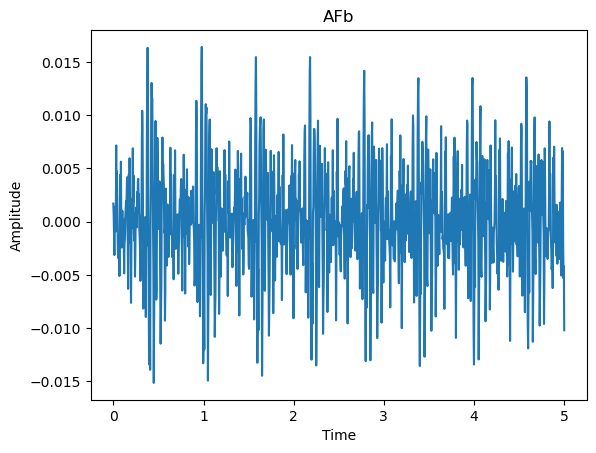

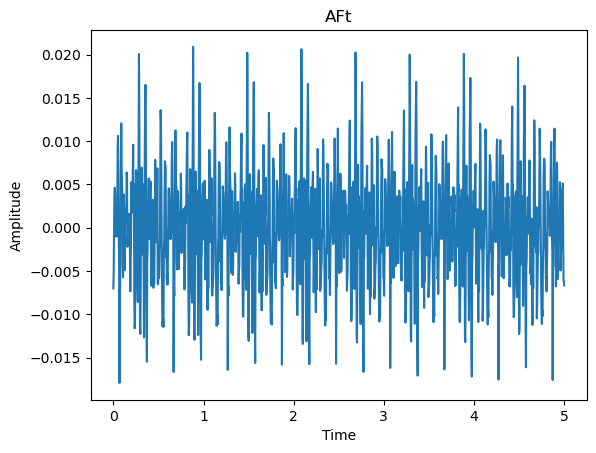

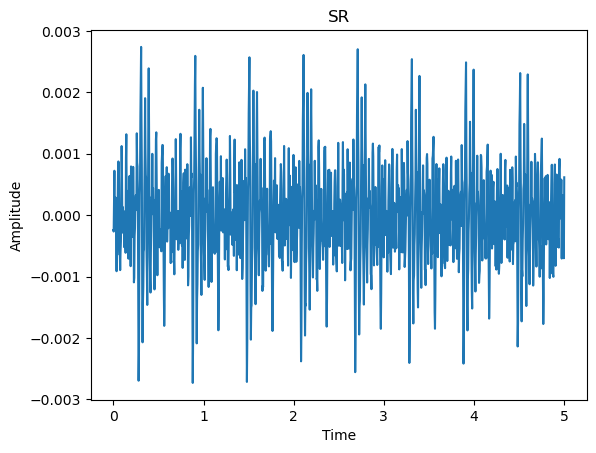

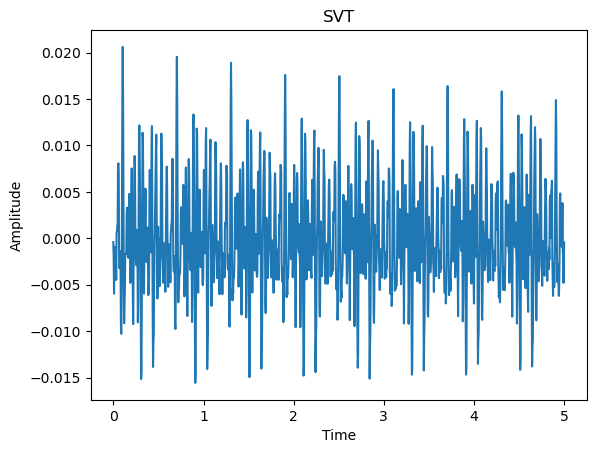

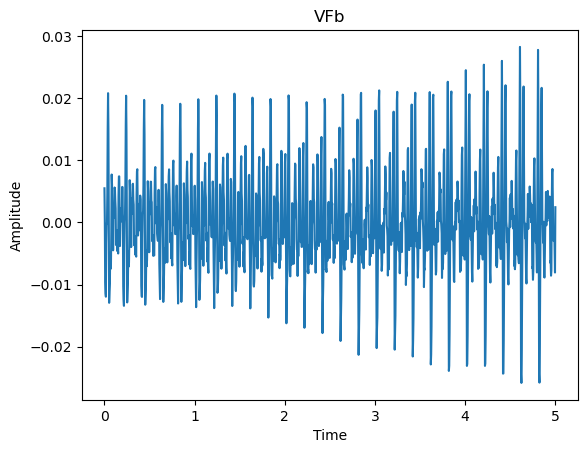

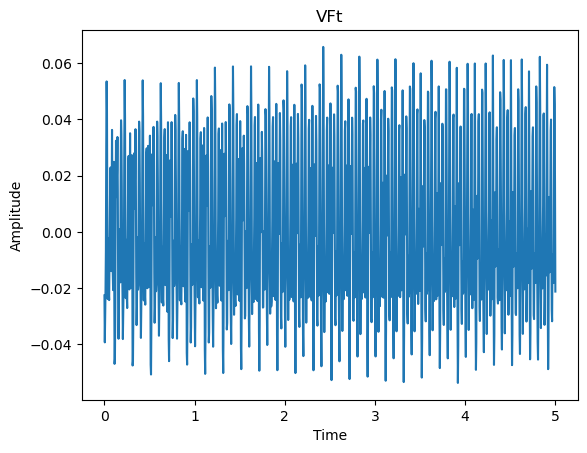

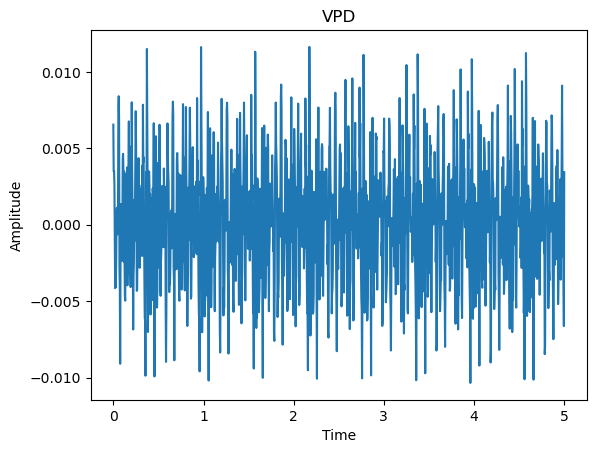

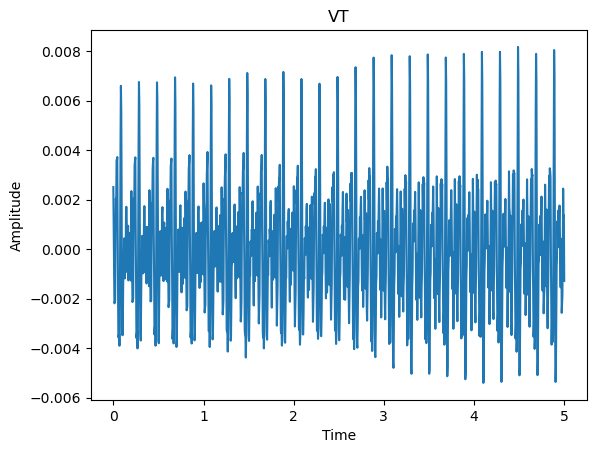

In [47]:
avg_signal_by_cat_dict = getAveragedCategorySignals()
for label, signal in getAveragedCategorySignals().items():
    plotSignal(len(signal), signal, label)

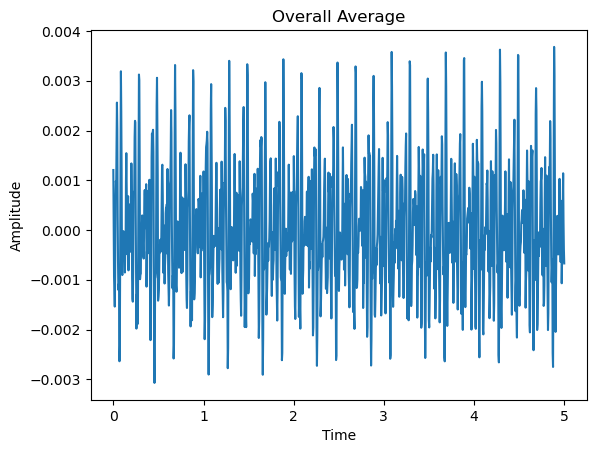

In [46]:
avg_overall = getAverageSignal()
plotSignal(len(avg_overall), avg_overall, "Overall Average")

In [51]:
def generateSignal(n, sampleLength = 5):
  sample_length = 1
  t = np.linspace(0, sampleLength, n)
  c1, c2 = random.randint(0, 150), random.randint(150, 250) #make some random coeffecients
  return np.sin(2 * np.pi * c1 * t) + 0.5 * np.sin(2 * np.pi * c2 * t)

def plotSignal(n, x, title, sampleLength = 5):
  t = np.linspace(0, sampleLength, n)
  plt.plot(t, x)
  plt.title(title)
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
  plt.show()

def sampleSignal(C, x):
  return C @ x

In [ ]:
rf  = getRandomFile()
rs = generateSignal(1250)
print(type(rf), len(rf), rf.shape)
print(type(rs), len(rs), rs.shape)

In [50]:
def main(x = getRandomFile()):
    # Solve y = Theta * s for "s"
    # Where Theta = C * Psi
    # Where Psi = "Basis Matrix" and C = Random Sampling Matrix
    # Remembering x = Psi * s
    
    #x = getRandomFile()#generateSignal(n)

    n = len(x) #1250 # dimension of "s" (and "x")
    p = n//5   #250  # number of measurements, dim(y), we'll try 20%
    C = np.random.randn(p, n)
    
    y = sampleSignal(C, x) #this is just: C @ x
    
    #Generate the Fourier Basis using Discrete Cosine Transform method
    Psi = dct(np.eye(n), norm='ortho') #build from Identity matrix
    
    Theta = C @ Psi
    
    # L1 Minimum Norm Solution s_L1
    def L1_norm(x):
      return np.linalg.norm(x,ord=1)
    
    constr = ({'type': 'eq', 'fun': lambda x: Theta @ x-y})
    x0 = np.linalg.pinv(Theta) @ y # initialize with L2 solution (psuedoinverse)
    res = minimize(L1_norm, x0, method='SLSQP', constraints=constr)
    s_L1 = res.x

    x_reconstructed_L1 = Psi @ s_L1
    x_reconstructed_L2 = Psi @ x0
    return x, s_L1, Psi, C

In [ ]:
# L2 Minimum norm solution s_L2
s_L2 = np.linalg.pinv(Theta) @ y

In [ ]:
fix, axs = plt.subplots(2, 2)
axs = axs.reshape(-1)
axs[0].plot(s_L1, color='y')
axs[0].set_ylim(-0.2, 0.2)
axs[0].set_title('L1 Norm')

axs[1].plot(s_L2, color='c')
axs[1].set_ylim(-0.2, 0.2)
axs[1].set_title('L2 Norm')

axs[2].hist(s_L1, bins=np.arange(-0.105, 0.105, 0.01), rwidth=0.9)
#axs[2].set_title('L1 Norm')

axs[3].hist(s_L2, bins=np.arange(-0.105, 0.105, 0.01), rwidth=0.9)
#axs[3].set_title('L2 Norm')

plt.show()

1250


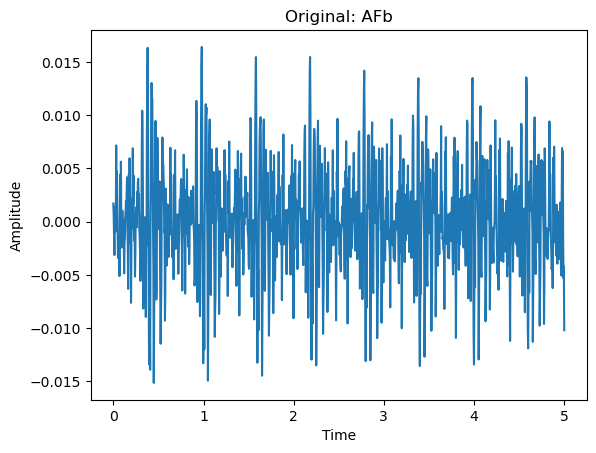

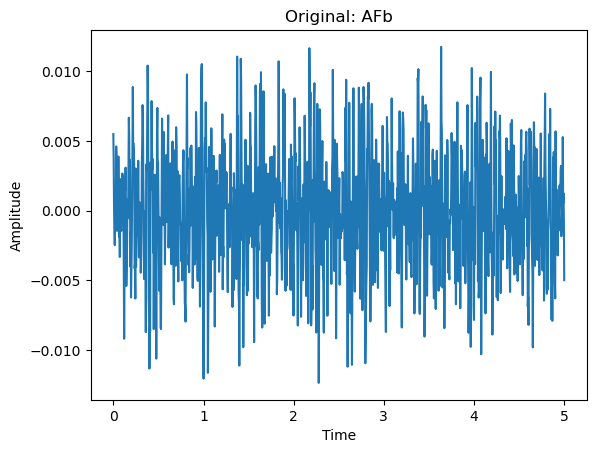

Mean Squared Error (MSE) 1: 1.317e-05
Mean Squared Error (MSE) 2: 1.904e-05
Mean Squared Error (MSE) X: 0.6245
1250


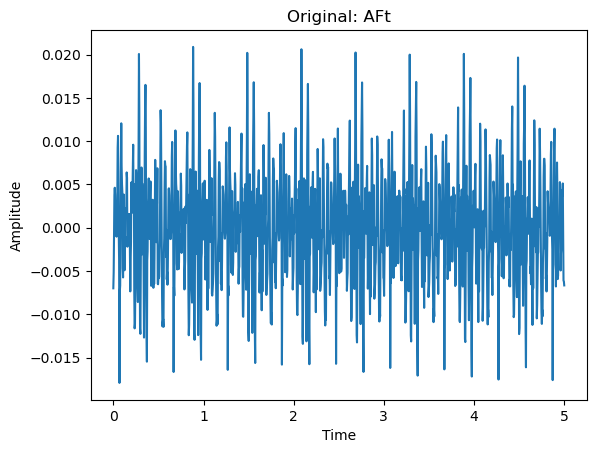

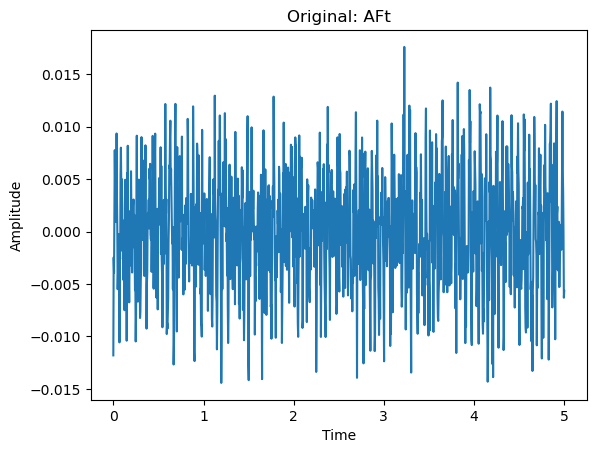

Mean Squared Error (MSE) 1: 3.093e-05
Mean Squared Error (MSE) 2: 3.439e-05
Mean Squared Error (MSE) X: 0.625
1250


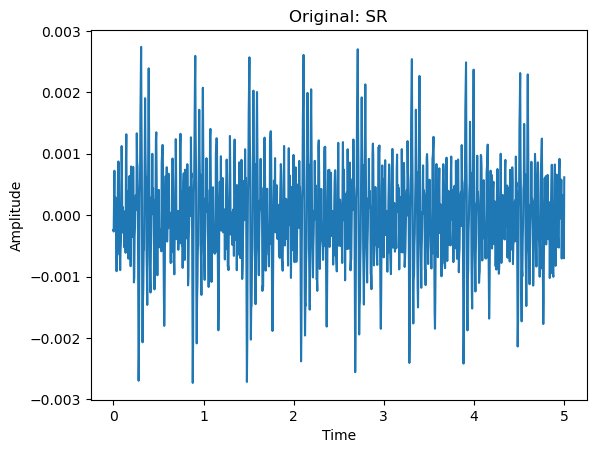

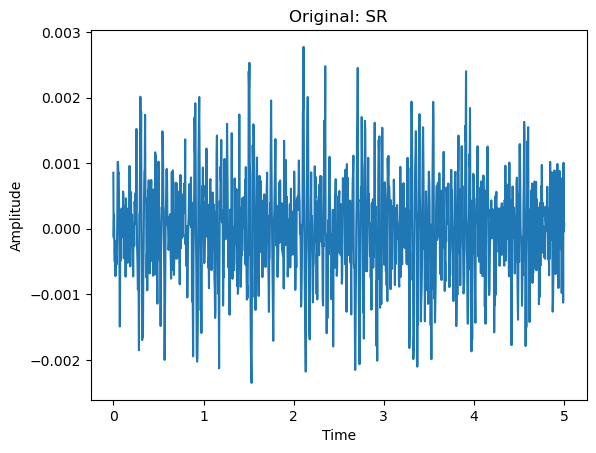

Mean Squared Error (MSE) 1: 3.958e-07
Mean Squared Error (MSE) 2: 5.312e-07
Mean Squared Error (MSE) X: 0.6245
1250


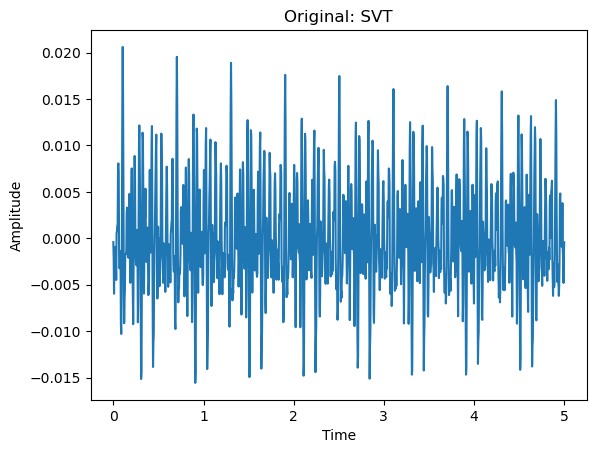

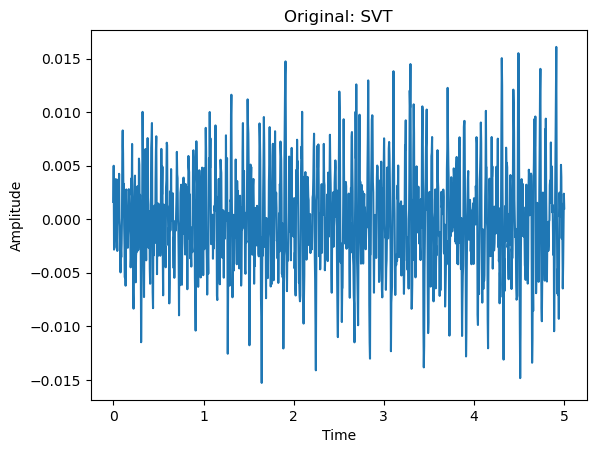

Mean Squared Error (MSE) 1: 1.427e-05
Mean Squared Error (MSE) 2: 2.672e-05
Mean Squared Error (MSE) X: 0.6244
1250


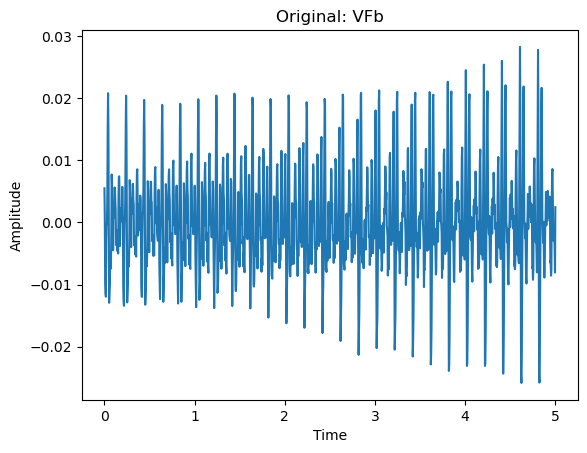

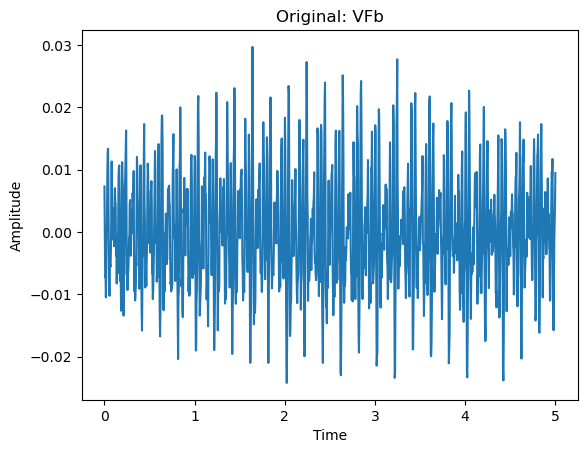

Mean Squared Error (MSE) 1: 2.041e-05
Mean Squared Error (MSE) 2: 5.267e-05
Mean Squared Error (MSE) X: 0.6245
1250


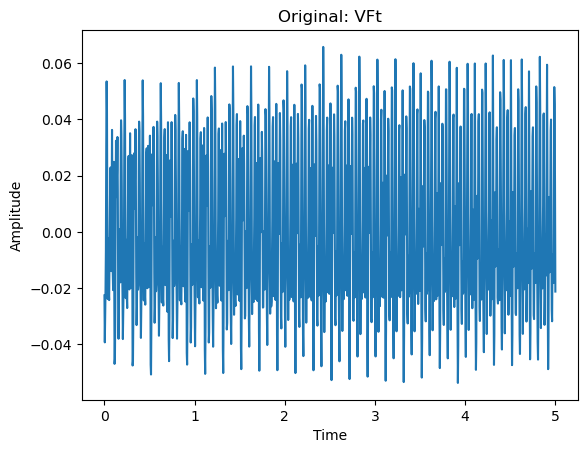

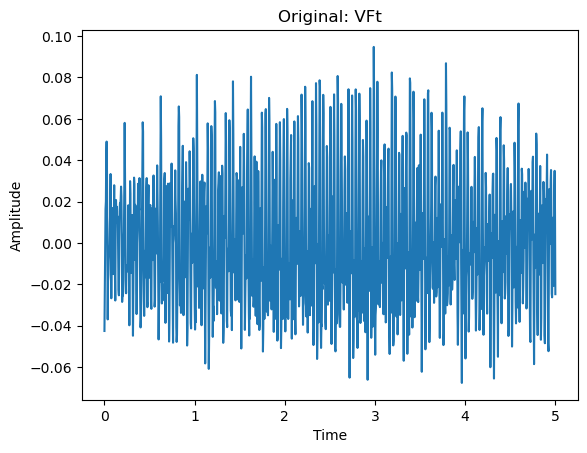

Mean Squared Error (MSE) 1: 0.0001925
Mean Squared Error (MSE) 2: 0.0006024
Mean Squared Error (MSE) X: 0.6253
1250


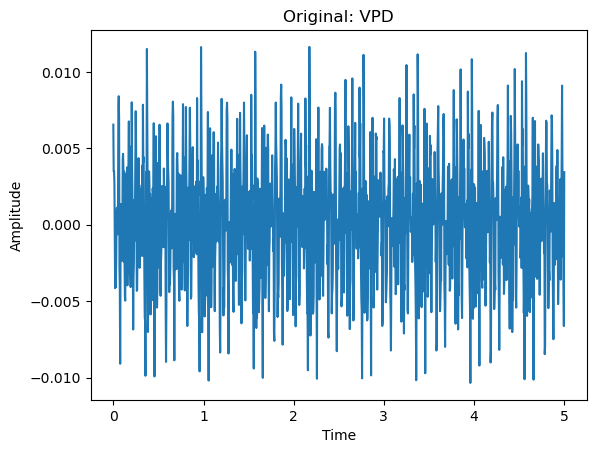

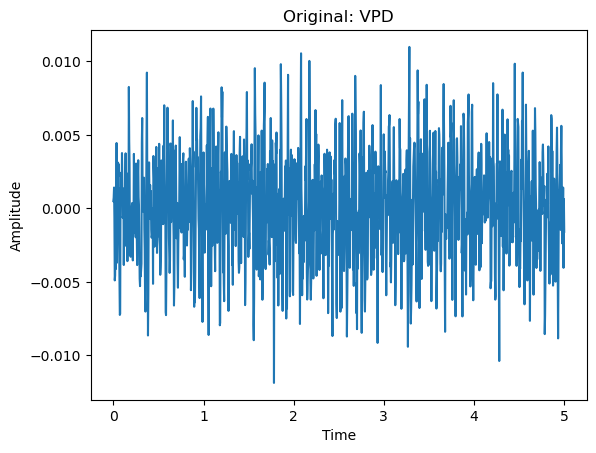

Mean Squared Error (MSE) 1: 1.089e-05
Mean Squared Error (MSE) 2: 1.372e-05
Mean Squared Error (MSE) X: 0.6246
1250


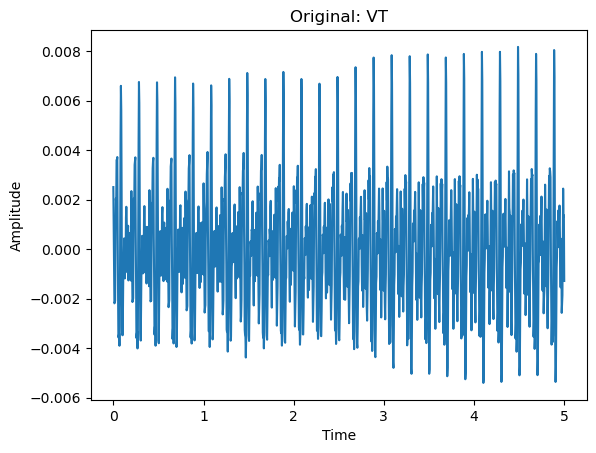

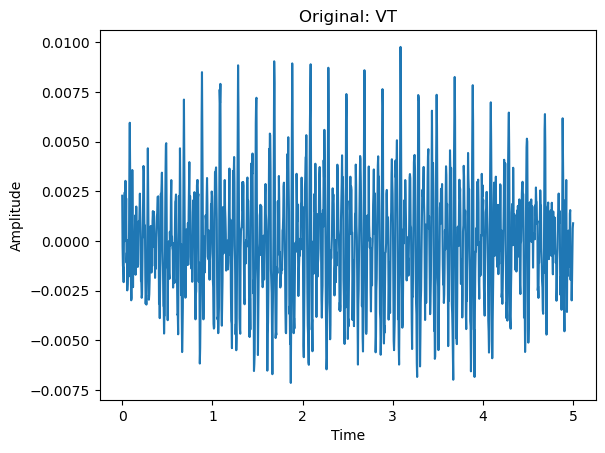

Mean Squared Error (MSE) 1: 2.332e-06
Mean Squared Error (MSE) 2: 5.371e-06
Mean Squared Error (MSE) X: 0.6245


In [37]:
for label, signal in getAveragedCategorySignals().items():
    x, s_L1, s_L2, Psi = main(signal) ########################### REWORK PARAMS
    x_reconstructed_L1 = Psi @ s_L1
    x_reconstructed_L2 = Psi @ s_L2

    n = len(x)
    temp_title = "Original: " + label
    plotSignal(n, x, temp_title)
    plotSignal(n, x_reconstructed_L1, temp_title + "")
    #plotSignal(n, x_reconstructed_L2, "x recon l2")

    mse1 = np.mean((x - x_reconstructed_L1) ** 2)
    mse2 = np.mean((x - x_reconstructed_L2) ** 2)
    mseBullshit = np.mean((x - generateSignal(n)) ** 2)

    f = open("resultsReal.txt", "a")
    f.write(f'{mse1:.4}, {mse2:.4}, {mseBullshit:.4}\n')
    f.close()

    print(f'Mean Squared Error (MSE) 1: {mse1:.4}')
    print(f'Mean Squared Error (MSE) 2: {mse2:.4}')
    print(f'Mean Squared Error (MSE) X: {mseBullshit:.4}')

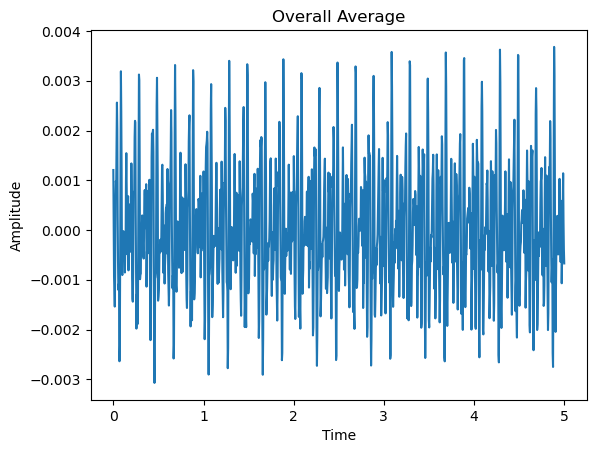

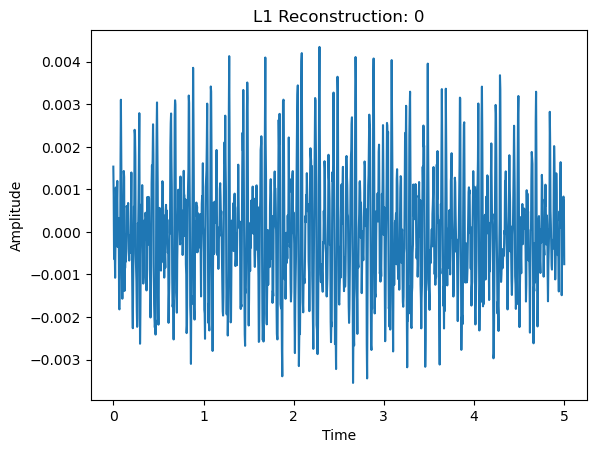

0 MSE: 5.769069244134268e-07 R: 0.8526513980335724


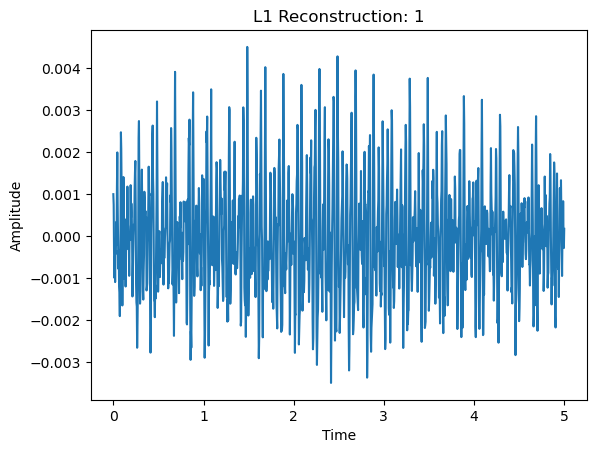

1 MSE: 4.936696039113853e-07 R: 0.8579020289922472


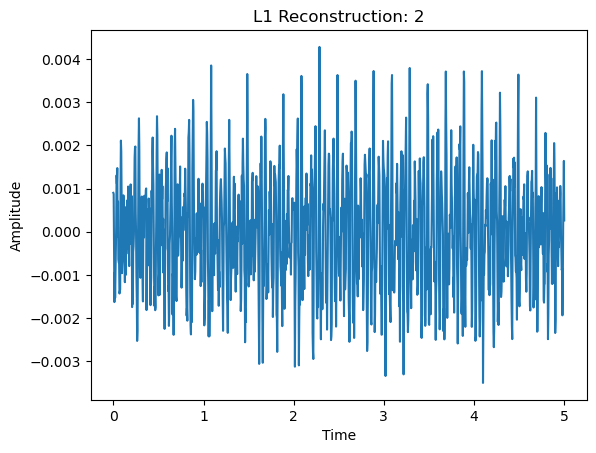

2 MSE: 5.007442474840347e-07 R: 0.8567721458041304


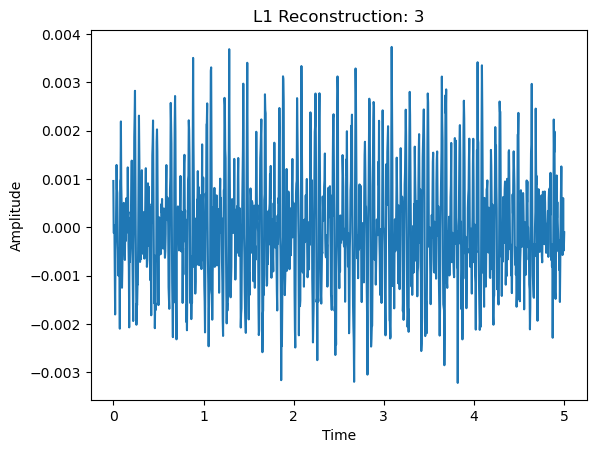

3 MSE: 5.183251759952308e-07 R: 0.832776507543796


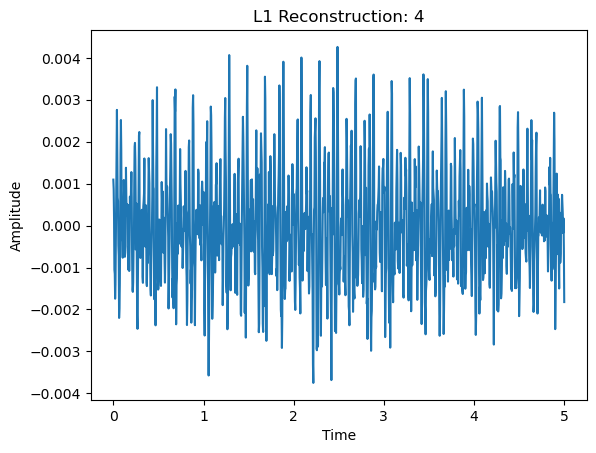

4 MSE: 5.392056059888963e-07 R: 0.8459264747786515


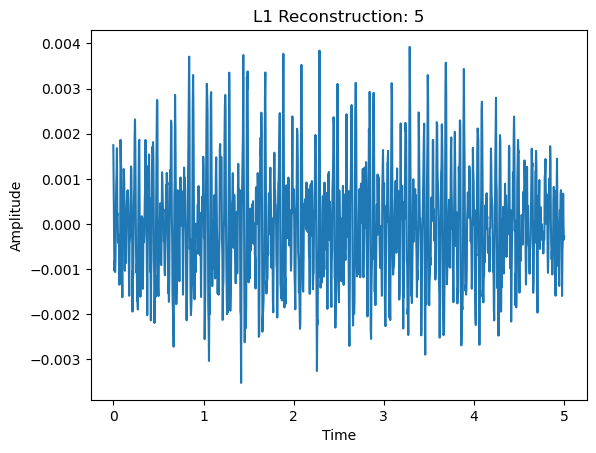

5 MSE: 5.180651967927104e-07 R: 0.838716561654791


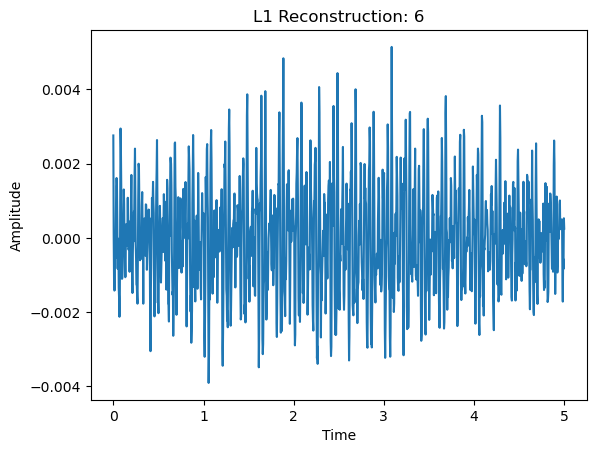

6 MSE: 6.429860625583107e-07 R: 0.8311301604028549


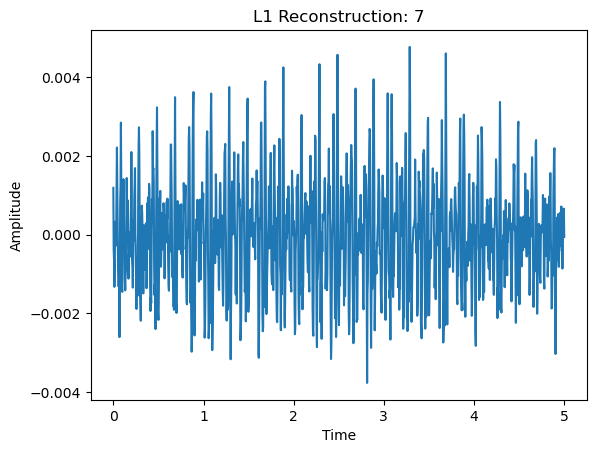

7 MSE: 5.818547998697257e-07 R: 0.8391118846923339


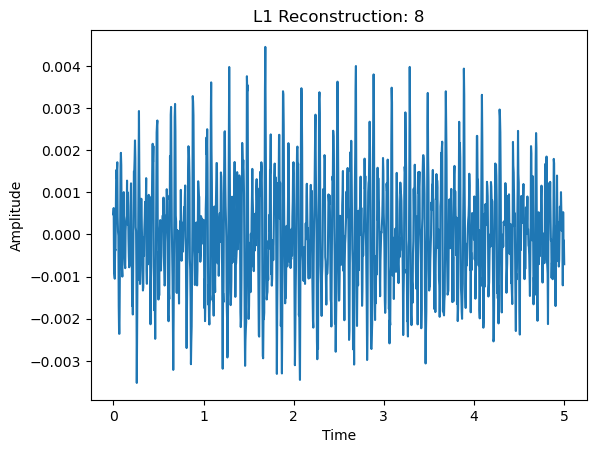

8 MSE: 6.44786693255387e-07 R: 0.8174960103696637


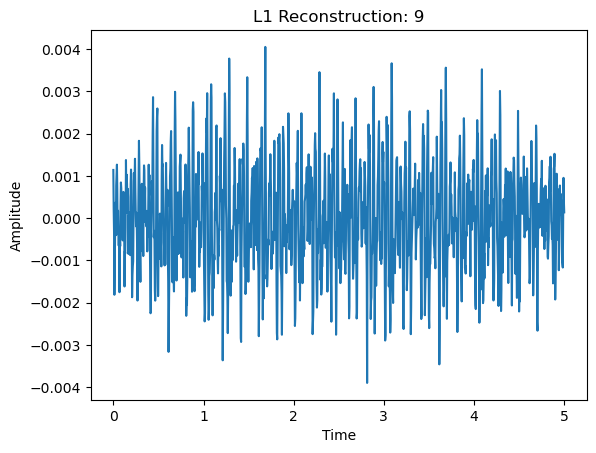

9 MSE: 5.360164618131676e-07 R: 0.8296441284140859


In [66]:
avg_overall = getAverageSignal()
plotSignal(len(avg_overall), avg_overall, "Overall Average")
best = 10
keep_C = None

for i in range(10):
    x, s_L1, Psi, C = main(avg_overall)
    x_reconstructed_L1 = Psi @ s_L1

    n = len(x)
    plotSignal(n, x_reconstructed_L1, "L1 Reconstruction: " + str(i))

    mse1 = np.mean((x - x_reconstructed_L1) ** 2)
    R = correlCo(x, x_reconstructed_L1)
    print(f"{i} MSE: {mse1} R: {R}")
    if R < best:
        best = R
        keep_C = C

    f = open("resultsFinal.txt", "a")
    f.write(f'{mse1}, {R}\n')
    f.close()
f = open("resultsFinal.txt", "a")
f.write(f'{best} was the best R, that C can be saved C.pkl\n')
f.close()

In [62]:
import pickle

with open('C.pkl', 'wb') as file:
    pickle.dump(keep_C, file)
print(best, keep_C)

with open('C.pkl', 'rb') as file:
    read_C = pickle.load(file)

print (read_C[:10], keep_C[:10])

b'\tQ\xacU\x95\xed\x04\xc0f\x16'


In [65]:
def mean(someList):
    total = 0
    for a in someList:
        total += float(a)
    mean = total/len(someList)
    return mean
def standDev(someList):
    listMean = mean(someList)
    dev = 0.0
    for i in range(len(someList)):
        dev += (someList[i]-listMean)**2
    dev = dev**(1/2.0)
    return dev
def correlCo(someList1, someList2):

    # First establish the means and standard deviations for both lists.
    xMean = mean(someList1)
    yMean = mean(someList2)
    xStandDev = standDev(someList1)
    yStandDev = standDev(someList2)
    # r numerator
    rNum = 0.0
    for i in range(len(someList1)):
        rNum += (someList1[i]-xMean)*(someList2[i]-yMean)

    # r denominator
    rDen = xStandDev * yStandDev

    r =  rNum/rDen
    return r